# Cell clustering notebook

Note: this notebook should be run after `example_pixel_clustering.ipynb` in the same Docker session

In [ ]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import feather
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from ark.analysis import visualize
from ark.phenotyping import som_utils
from ark.utils import data_utils, io_utils, load_utils, plot_utils

### Load parameters for cell clustering (computed by pixel_clustering)

The file name should be in the form `{cluster_prefix_from_pixel_clustering}_cell_clustering_params.json`. Make sure to set `base_dir` to the same value used in `example_pixel_clustering.ipynb`.

The following params are loaded:

* `fovs`: the set of fovs
* `channels`: the subset of markers
* `segmentation_dir`: the path to the directory containing your segmentations (generated from Segment_Image_Data.ipynb). Should be set to the same value as `base_dir` in `example_pixel_clustering.ipynb`
* `pixel_consensus_dir`: the name of the directory containing pixel data with the pixel SOM and consensus cluster assignments
* `pc_chan_avg_cluster_name`: the name of the file containing the average marker channel expression per pixel SOM cluster, used for the visualization of weighted channel average per cell
* `pc_chan_avg_hCluster_cap_name`: the name of the file containing the average marker channel expression per pixel meta cluster, used for the visualization of weighted channel average per cell

In [ ]:
# define the base dir
base_dir = "../data/granulomaCohort_allData"

# change the prefix of cell_clustering_params_name accordingly
cell_clustering_params_name = 'test_cell_clustering_params.json'

In [ ]:
# load the params
with open(os.path.join(base_dir, cell_clustering_params_name)) as fh:
    cell_clustering_params = json.load(fh)
    
# assign the params to variables
fovs = cell_clustering_params['fovs']
channels = cell_clustering_params['channels']
segmentation_dir = cell_clustering_params['segmentation_dir']
pixel_consensus_dir = cell_clustering_params['pixel_consensus_dir']
pc_chan_avg_cluster_name = cell_clustering_params['pc_chan_avg_cluster_name']
pc_chan_avg_hCluster_cap_name = cell_clustering_params['pc_chan_avg_hCluster_cap_name']

* `cell_table_name`: name of the cell table created by `Segment_Image_Data.ipynb`, should be placed in the root of `base_dir`. You can use either the normalized or arcsinh versions.

In [ ]:
cell_table_name = 'cell_table_size_normalized.csv'

### Train cell SOM

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used. The following data directories/files will be created for pixel clustering:

* `{cluster_prefix}_cell_clustered_name`: file to store cell data with just the SOM cluster assignments
* `{cluster_prefix}_cell_consensus_dir`: directory to store cell data with the SOM and consensus cluster assignments
* `{cluster_prefix}_cell_weights_name`: file name to place the cell SOM weights

In [ ]:
# explicitly set cluster_prefix to override datetime default
cluster_prefix = None

if cluster_prefix is None:
    cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')
    
# define the cell SOM cluster and cell SOM weights paths, explicitly set the variables to use custom names
cell_clustered_name = '%s_cell_mat_clustered.feather' % cluster_prefix
cell_consensus_name = '%s_cell_mat_consensus.feather' % cluster_prefix
cell_weights_name = '%s_cell_weights.feather' % cluster_prefix

* `cluster_col`: whether to use pixel SOM or meta cluster counts for training. Set to 'cluster' or 'hCluster_cap' respectively

In [ ]:
cluster_col = 'hCluster_cap'

For a full set of parameters you can customize for train_cell_som, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.train_cell_som>cell training docs</a>

In [ ]:
# create the cell-level SOM weights
som_utils.train_cell_som(
    fovs,
    base_dir,
    cell_table_name=cell_table_name,
    pixel_consensus_dir=pixel_consensus_dir,
    weights_name=cell_weights_name,
    cluster_col=cluster_col,
    num_passes=10
)

### Assign cell SOM clusters

In [ ]:
# use cell SOM weights to assign cell clusters
som_utils.cluster_cells(
    base_dir,
    weights_name=cell_weights_name,
    cell_cluster_name=cell_clustered_name
)

### Visualize the number of cells per SOM cluster

In [ ]:
# compute the number of cells per SOM cluster
cell_som_counts = som_utils.compute_cell_cluster_counts(
    base_dir,
    cell_clustered_name,
    column_prefix=cluster_col,
    cell_cluster_col='cluster'
)

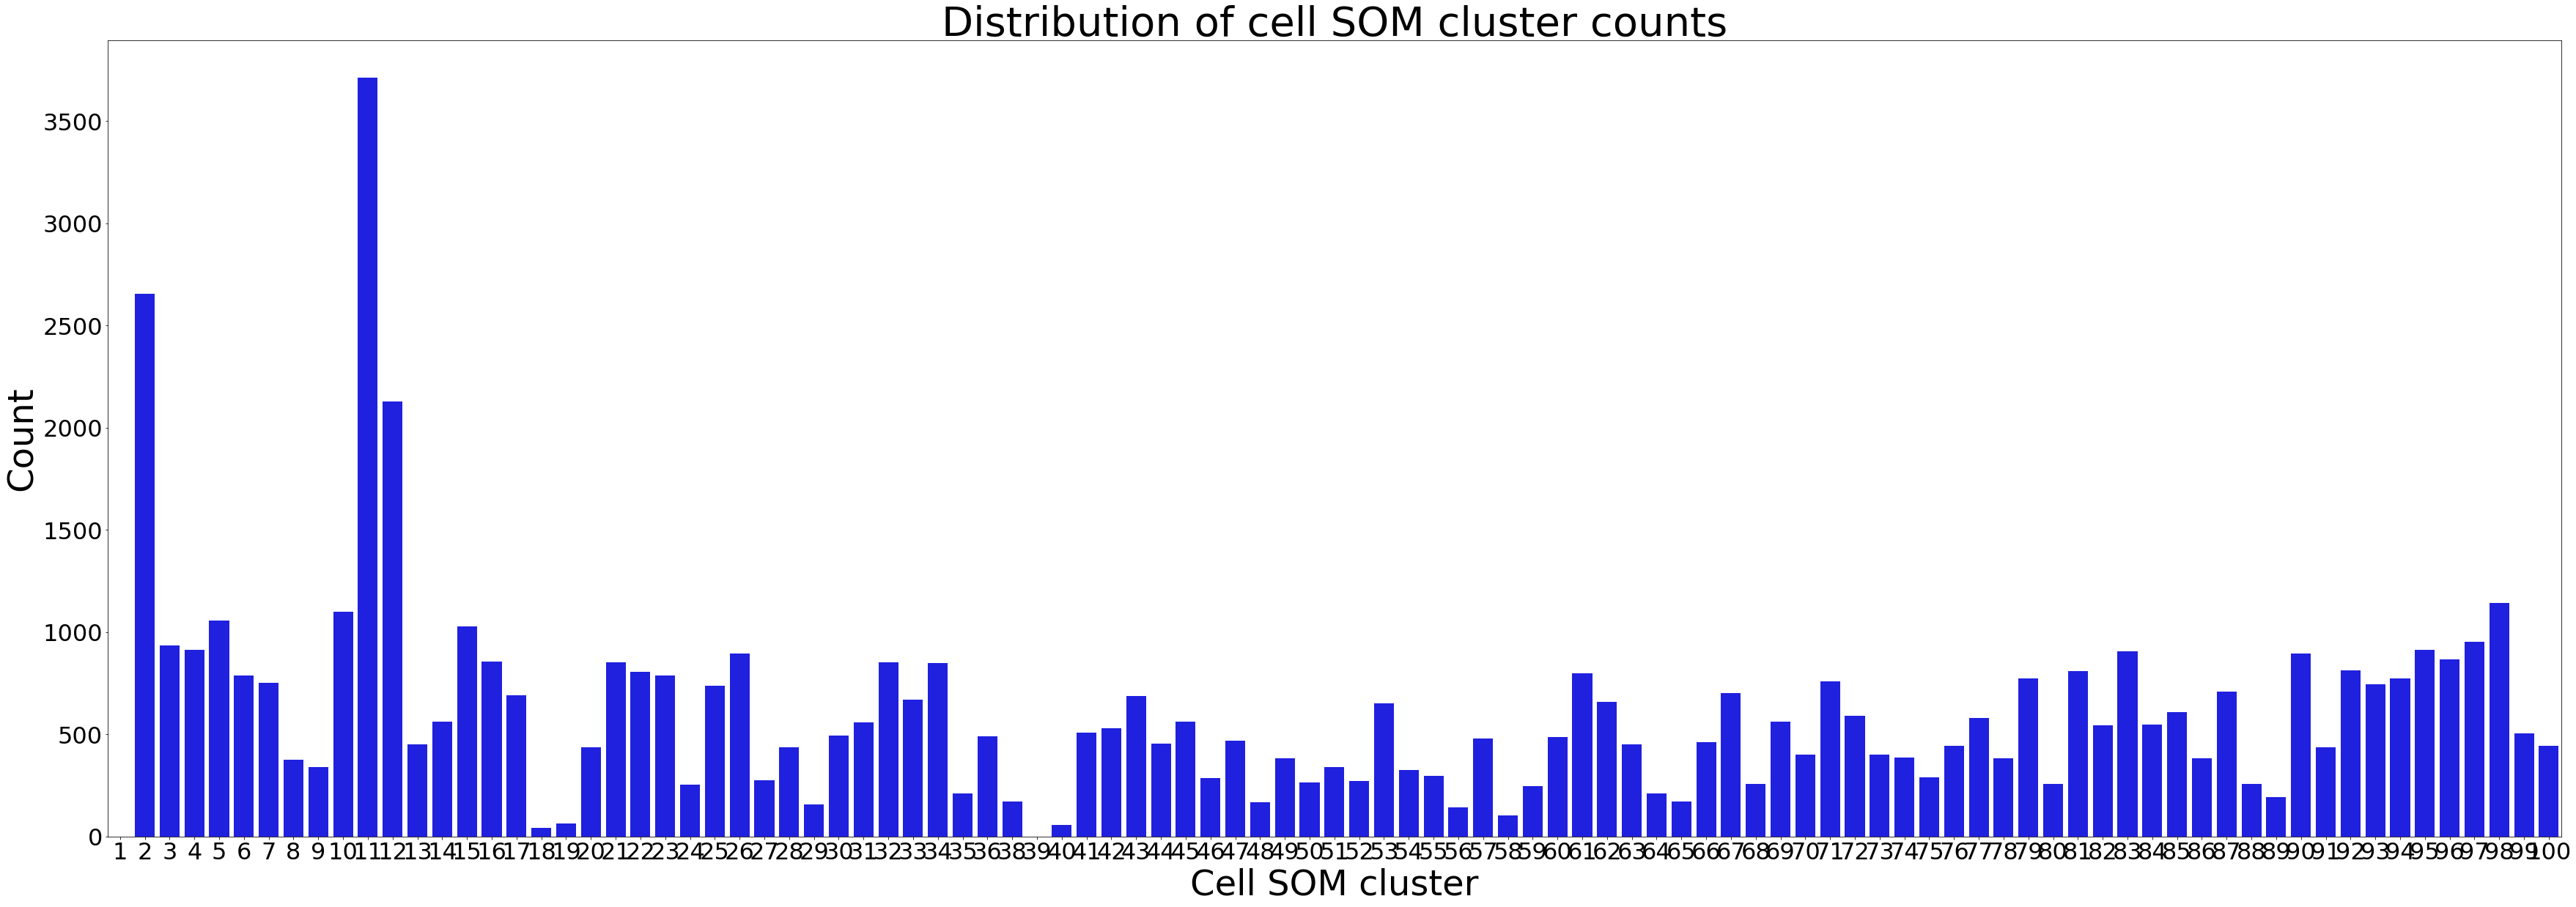

In [10]:
# visualize the cell counts per SOM cluster in a barchart
_ = plt.figure(figsize=(60, 20))
_ = sns.barplot(x=cell_som_counts['cluster'], y=cell_som_counts['count'], palette=['#0000FF' for i in range(cell_som_counts.shape[0])])
_ = plt.title('Distribution of cell SOM cluster counts', fontsize=56)
_ = plt.xlabel('Cell SOM cluster', fontsize=48)
_ = plt.ylabel('Count', fontsize=48)
_ = plt.xticks(fontsize=32)
_ = plt.yticks(fontsize=32)

### Visualize the weighted cell SOM cluster average heatmap over channels (z-scored)

* See documentation of `compute_p2c_weighted_channel_avg` for how weighted cell channel average is computed: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.compute_p2c_weighted_channel_avg>cell channel weighting docs</a>
* The weighted cell channel average result will also be used for interactive reclustering
* Results are also saved as `cell_channel_avg_cluster.feather` and `cell_channel_avg_hCluster_cap` in `base_dir`

In [ ]:
# read in pixel cluster channel average tables computed by example_pixel_clustering.ipynb
pixel_cluster_channel_avg_cluster = feather.read_dataframe(os.path.join(base_dir, pc_chan_avg_cluster_name))
pixel_cluster_channel_avg_hCluster_cap = feather.read_dataframe(os.path.join(base_dir, pc_chan_avg_hCluster_cap_name))

In [ ]:
# compute number of pixel SOM clusters per cell
pixel_cluster_counts_per_cell = som_utils.create_c2pc_data(
    fovs, os.path.join(base_dir, pixel_consensus_dir), os.path.join(base_dir, cell_table_name), cluster_col='cluster'
)

# compute number of pixel meta clusters per cell
pixel_hCluster_cap_counts_per_cell = som_utils.create_c2pc_data(
    fovs, os.path.join(base_dir, pixel_consensus_dir), os.path.join(base_dir, cell_table_name), cluster_col='hCluster_cap'
)

In [ ]:
# compute the weighted channel average per cell (based on pixel SOM cluster counts)
cell_channel_avg_cluster = som_utils.compute_p2c_weighted_channel_avg(
    pixel_cluster_channel_avg_cluster, pixel_cluster_counts_per_cell, fovs=fovs, cluster_col='cluster'
)

# compute the weighted channel average per cell (based on pixel meta cluster counts)
cell_channel_avg_hCluster_cap = som_utils.compute_p2c_weighted_channel_avg(
    pixel_cluster_channel_avg_hCluster_cap, pixel_hCluster_cap_counts_per_cell, fovs=fovs, cluster_col='hCluster_cap'
)

In [ ]:
# save cell_channel_avg_cluster and cell_channel_avg_hCluster_cap
feather.write_dataframe(
    cell_channel_avg_cluster, os.path.join(base_dir, 'cell_channel_avg_cluster.feather')
)

feather.write_dataframe(
    cell_channel_avg_hCluster_cap, os.path.join(base_dir, 'cell_channel_avg_hCluster_cap.feather')
)

In [ ]:
# compute weighted average channel expression for each cell som cluster (z-scored)
# needs cell_channel_avg_{cluster_col} computed from example_pixel_clustering
cell_cluster_channel_avg_cluster = som_utils.compute_cell_cluster_channel_avg(
    fovs,
    channels,
    base_dir,
    os.path.join(base_dir, 'cell_channel_avg_%s.feather' % cluster_col),
    cell_clustered_name,
    'cluster'
)

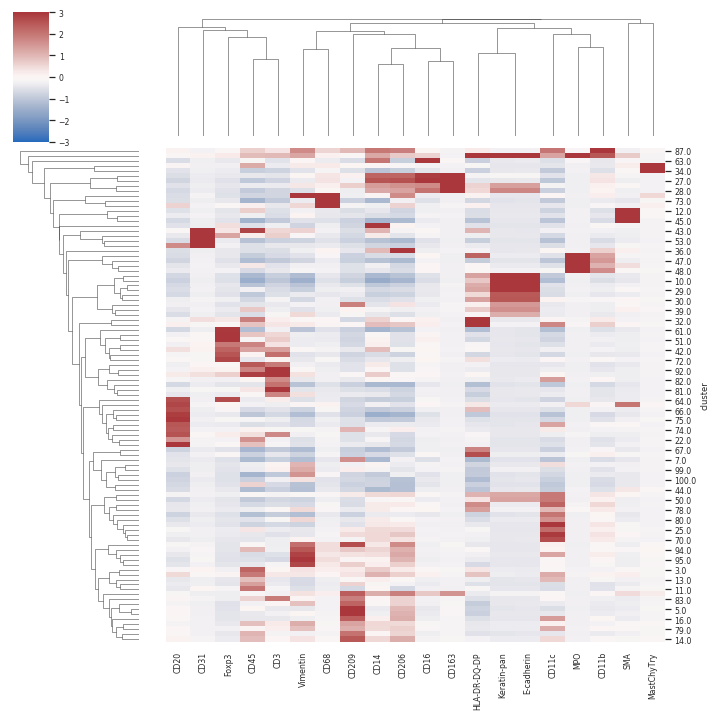

In [16]:
# visualize the cell SOM cluster weighted average heatmap over channels (z-scored)
# using weighted average discretizes values better since we take advantage of pixel cluster info
visualize.draw_heatmap(
    data=cell_cluster_channel_avg_cluster.drop(columns='cluster').values,
    x_labels=cell_cluster_channel_avg_cluster['cluster'],
    y_labels=cell_cluster_channel_avg_cluster.drop(columns='cluster').columns.values,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    colormap='vlag'
)

In [ ]:
# compute the average number of pixel clusters per cell SOM cluster (z-scored)
avg_p2c_counts_cell_cluster = som_utils.compute_avg_p2c_counts(
    base_dir,
    cell_clustered_name,
    cluster_col,
    'cluster'
)

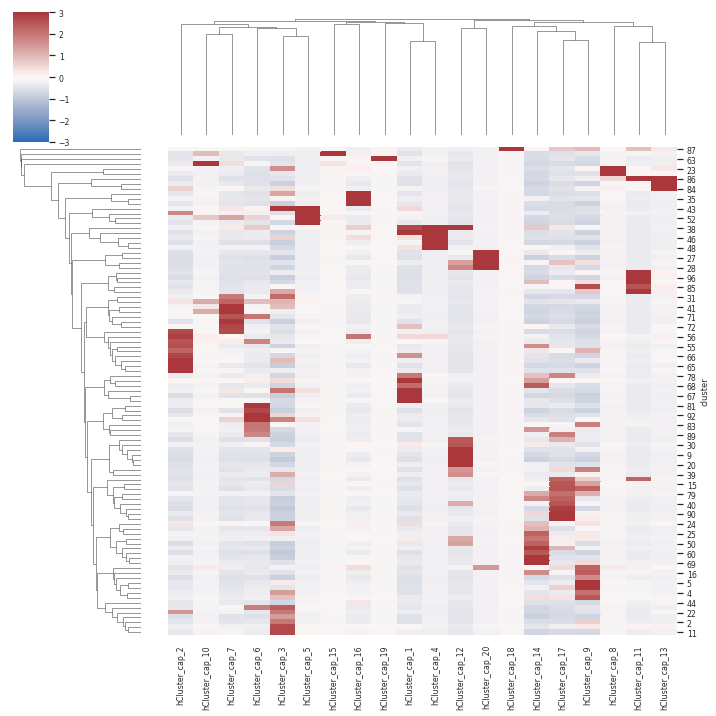

In [18]:
# visualize the average number of pixel clusters per cell SOM cluster (z-scored)
visualize.draw_heatmap(
    data=avg_p2c_counts_cell_cluster.drop(columns='cluster').values,
    x_labels=avg_p2c_counts_cell_cluster['cluster'],
    y_labels=avg_p2c_counts_cell_cluster.drop(columns='cluster').columns.values,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    colormap='vlag'
)

### Run cell consensus clustering

For a full set of parameters you can customize for cell_consensus_cluster, please consult: https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.cell_consensus_cluster

In [ ]:
# run hierarchical clustering based on cell SOM cluster assignments
som_utils.cell_consensus_cluster(
    base_dir=base_dir,
    cell_cluster_name=cell_clustered_name,
    column_prefix=cluster_col,
    cell_consensus_name=cell_consensus_name
)

In [ ]:
# compute the number of cells per meta cluster
cell_meta_counts = som_utils.compute_cell_cluster_counts(
    base_dir,
    cell_consensus_name,
    column_prefix=cluster_col,
    cell_cluster_col='hCluster_cap'
)

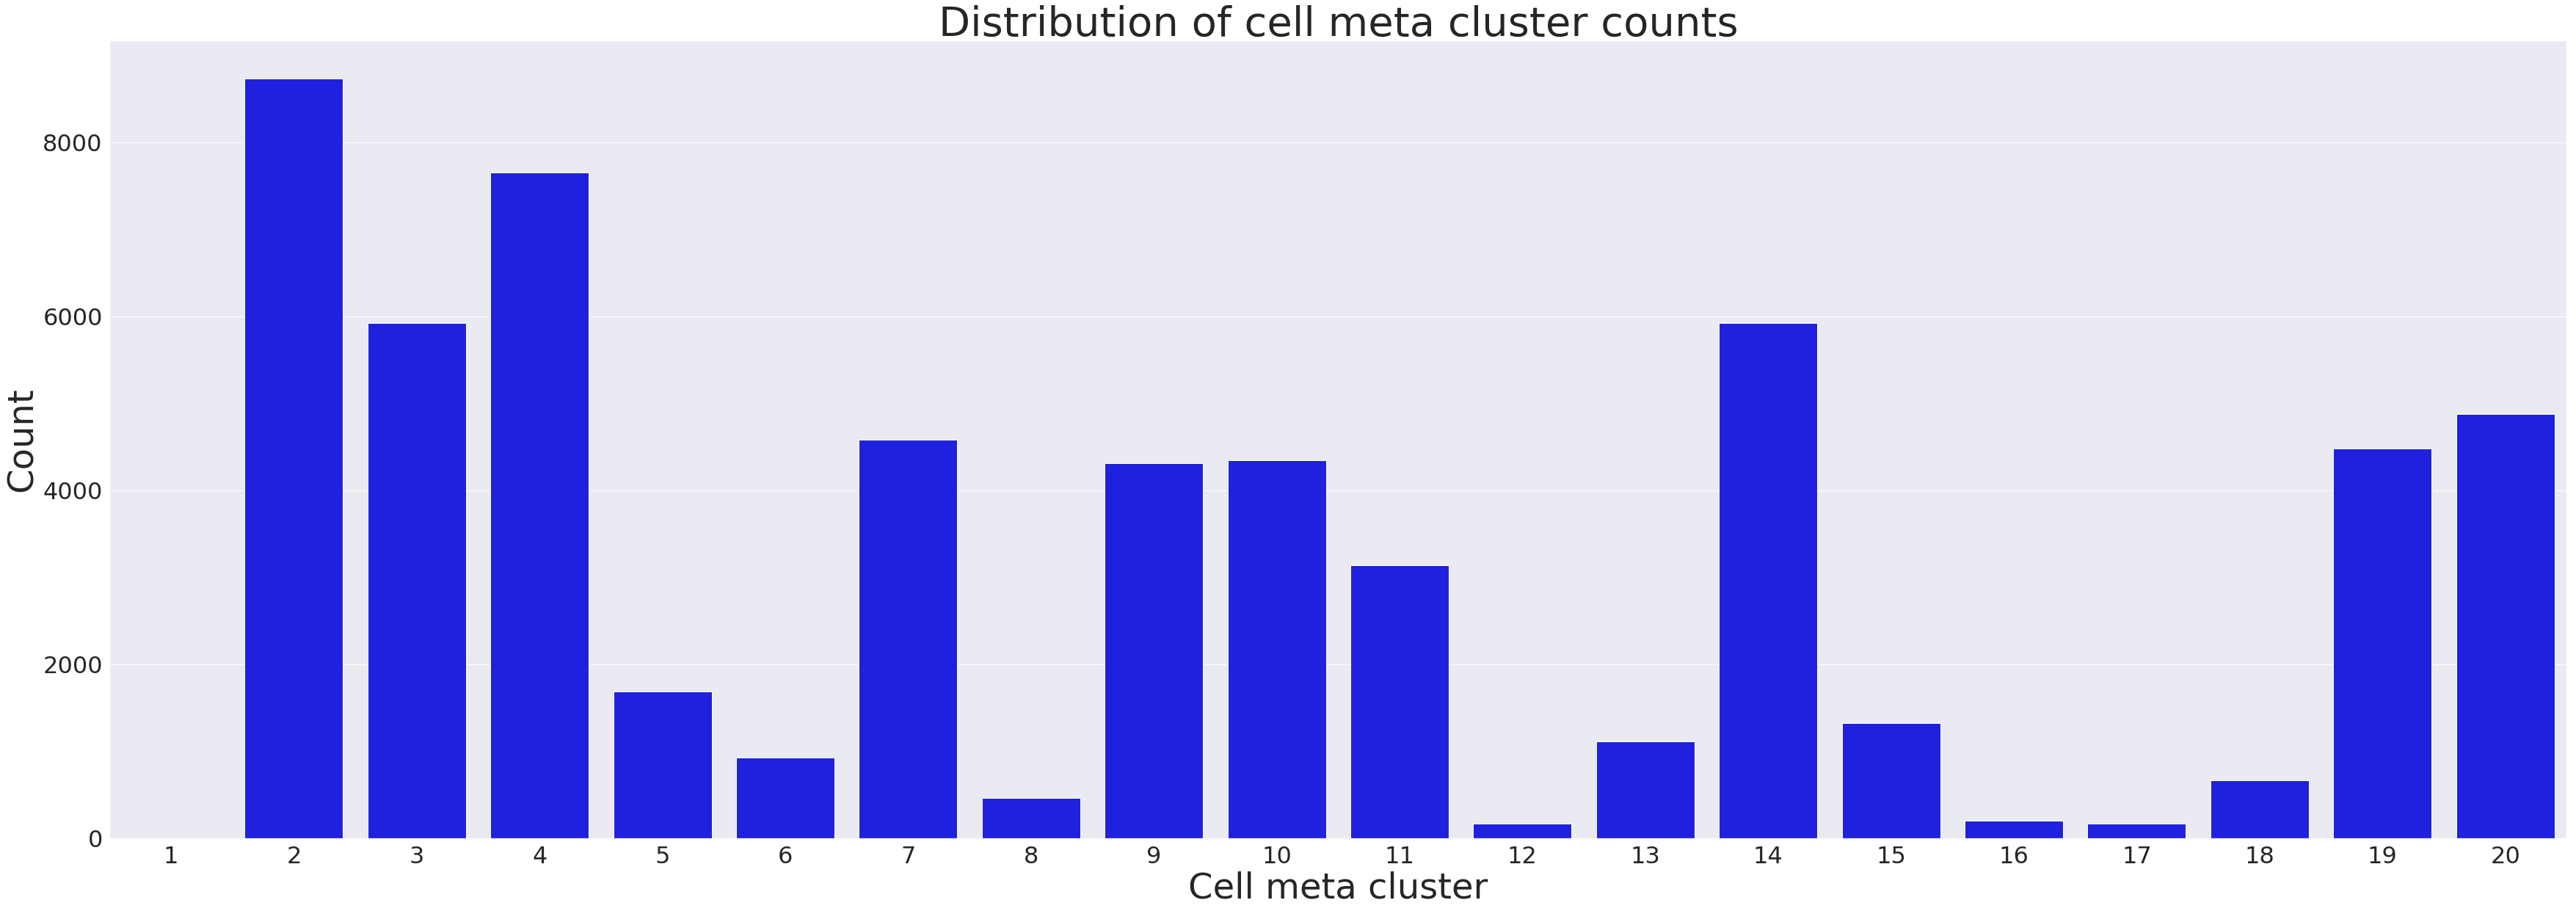

In [21]:
# visualize the cell counts per meta cluster in a barchart
_ = plt.figure(figsize=(60, 20))
_ = sns.barplot(x=cell_meta_counts['hCluster_cap'], y=cell_meta_counts['count'], palette=['#0000FF' for i in range(cell_meta_counts.shape[0])])
_ = plt.title('Distribution of cell meta cluster counts', fontsize=56)
_ = plt.xlabel('Cell meta cluster', fontsize=48)
_ = plt.ylabel('Count', fontsize=48)
_ = plt.xticks(fontsize=32)
_ = plt.yticks(fontsize=32)

In [ ]:
# compute weighted average channel expression for each cell som cluster (z-scored)
# needs cell_channel_avg_{cluster_col} computed from example_pixel_clustering
cell_cluster_channel_avg_hCluster_cap = som_utils.compute_cell_cluster_channel_avg(
    fovs,
    channels,
    base_dir,
    os.path.join(base_dir, 'cell_channel_avg_%s.feather' % cluster_col),
    cell_consensus_name,
    'hCluster_cap'
)

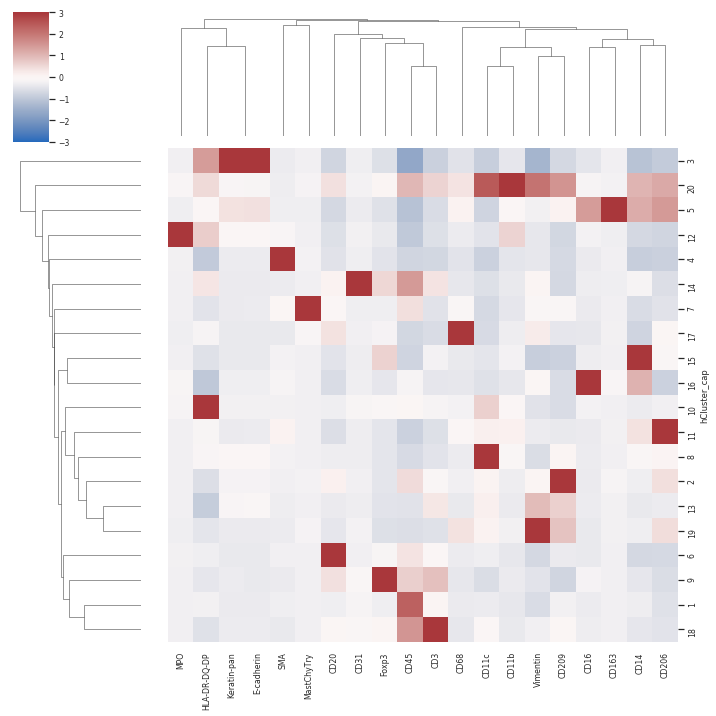

In [23]:
# visualize the cell meta cluster weighted average heatmap over channels (z-scored)
# using weighted average discretizes values better since we take advantage of pixel cluster info
visualize.draw_heatmap(
    data=cell_cluster_channel_avg_hCluster_cap.drop(columns='hCluster_cap').values,
    x_labels=cell_cluster_channel_avg_hCluster_cap['hCluster_cap'],
    y_labels=cell_cluster_channel_avg_hCluster_cap.drop(columns='hCluster_cap').columns.values,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    colormap='vlag'
)

In [ ]:
# compute the average number of pixel clusters per cell meta cluster (z-scored)
avg_p2c_counts_cell_hCluster_cap = som_utils.compute_avg_p2c_counts(
    base_dir,
    cell_consensus_name,
    cluster_col,
    'hCluster_cap'
)

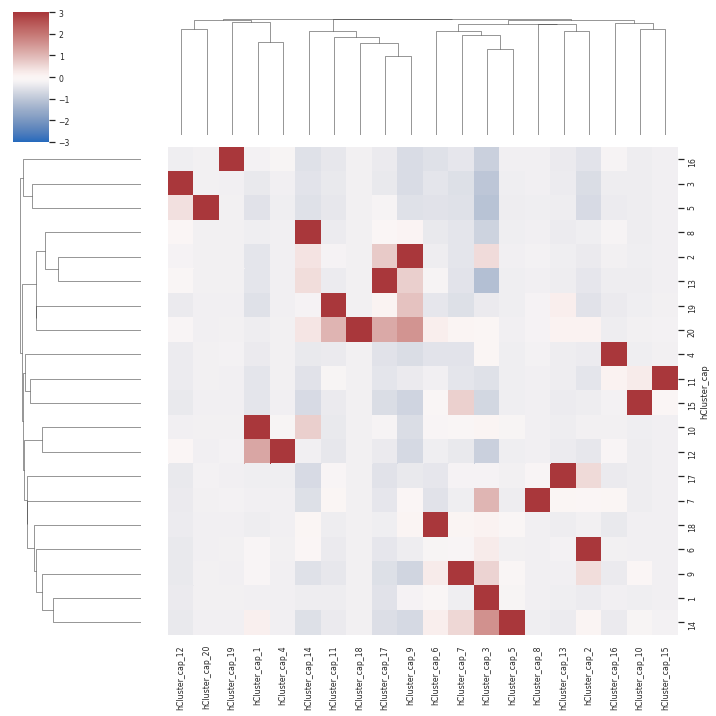

In [25]:
# visualize the average number of pixel clusters per cell meta cluster (z-scored)
visualize.draw_heatmap(
    data=avg_p2c_counts_cell_hCluster_cap.drop(columns='hCluster_cap').values,
    x_labels=avg_p2c_counts_cell_hCluster_cap['hCluster_cap'],
    y_labels=avg_p2c_counts_cell_hCluster_cap.drop(columns='hCluster_cap').columns.values,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    colormap='vlag'
)

### Visualize cell cluster overlay

In [ ]:
# select fovs to display
cell_fovs = ['fov6', 'fov7']

In [ ]:
# generate the cell cluster masks for each fov in cell_fovs
cell_cluster_masks = data_utils.generate_cell_cluster_mask(
    cell_fovs,
    base_dir,
    segmentation_dir,
    cell_consensus_name=cell_consensus_name,
    cluster_col='hCluster_cap'
)

* `save_pixel_masks`: replace with True if you want to save, files will be written as `{fov_name}_cell_mask.tiff` in `base_dir`

In [ ]:
save_cell_masks = False

if save_cell_masks:
    data_utils.save_fov_images(
        cell_fovs,
        base_dir,
        cell_cluster_masks,
        name_suffix='_cell_mask'
    )

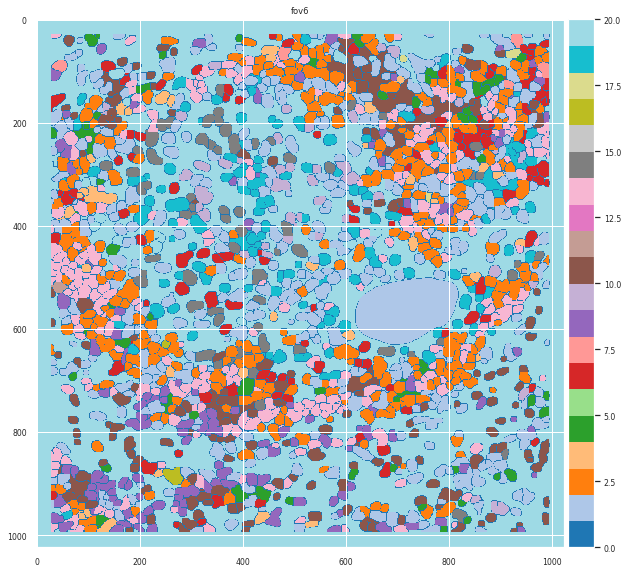

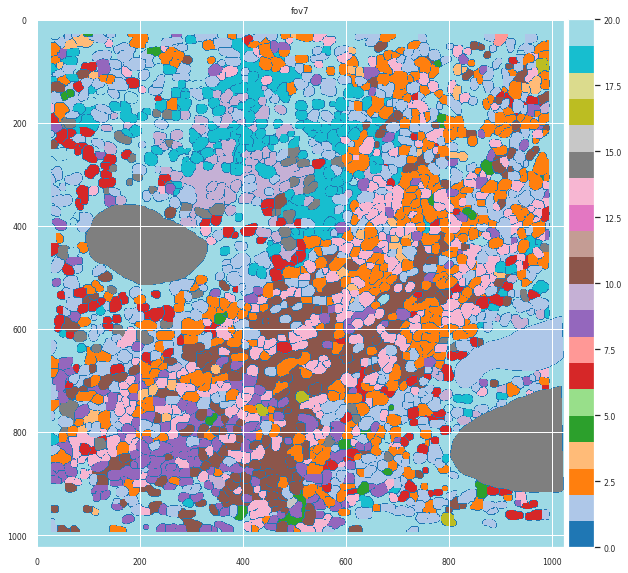

In [29]:
plot_utils.plot_clustering_result(
    cell_cluster_masks,
    cell_fovs
)